The question we're trying to answer is whether the first child  is more likely to be go over its due date. 

## Dataset

We will be leveraging the National Survey of Family Growth - Cycle 6 (2002) available on the [Center for Disease Control and Prevention's website](https://www.cdc.gov/nchs/nsfg/nsfg_cycle6.htm). It contains a wealth of information regarding women and pregnancies.

For this we will be looking `2002FemPreg.dat` file available from the above. Meanings for each of the columns/values is described in the [codebook](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NSFG/Cycle6Codebook-Pregnancy.pdf).

### Parsing

The `dat` file is a fixed-width file. In order to make sense of this we need to know how large each field is and what it represents. We'll take a stab at parsing this using the associated [STATA dictionary](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/stata/2002FemPreg.dct). 

#### DAT
```
           1 1     6 1     11093 1084     9 039 9   0  1 813             1093 13837                        1                5                                                                        116610931166 9201093                111             3    1   12  11         5391 110933316108432411211     2995 1212 69544441116122222 2 2224693215    000000000000000000000000000000000000003410.38939935294273869.3496019830486 6448.2711117047512 91231
           1 2     6 1     11166 1157     9 039 9   0  2 714             1166  6542112  2  05 1 4  5       51               1   41  4  201 20                                                        1166109311661093116611661231        111             3    1   14  11         5391 211663925115738501211 2 432 8701414 69544441116122222 2 2224693215    000000000000000000000000000000000000003410.38939935294273869.3496019830486 6448.2711117047512 91231
           ...
```

#### DCT 
```
infile dictionary {
    _column(1)      str12                             caseid  %12s  "RESPONDENT ID NUMBER"
   _column(13)       byte                           pregordr   %2f  "PREGNANCY ORDER (NUMBER)"
   _column(15)       byte                          howpreg_n   %2f  "BB-2 # OF WEEKS OR MONTHS CURRENTLY PREGNANT"
   _column(17)       byte                          howpreg_p   %1f  "BB-2 CURRENT PREGNANCY LENGTH REPORTED IN MONTHS OR WEEKS"
...
```

We want to extract the 3rd and 4th column - the 3rd giving us the column name and the 4th the size of the input (which essentially tells us the number of characters).

In [20]:
with open(r'2002FemPreg.dct') as f:
    infile = f.readline()
    col_dat = []
    for line in f.readlines():
        d = line.split()
        if d[0].startswith('_column'):
            col_dat.append((d[2],int(d[3][1:-1]))) # we want the name and the numerical portion of the format string
print(col_dat[:5])

[('caseid', 12), ('pregordr', 2), ('howpreg_n', 2), ('howpreg_p', 1), ('moscurrp', 1)]


`pandas` has a `read_fwf` method which we will leverage. It needs a list of widths and names for each column.

In [22]:
import pandas as pd
df = pd.read_fwf(r'2002FemPreg.dat', widths=[w for n,w in col_dat], names=[n for n,w in col_dat])

In [23]:
df.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,poverty_i,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,3410.389399,3869.349602,6448.271112,2,9,1231
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,3410.389399,3869.349602,6448.271112,2,9,1231
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231


### Data selection

We'll filter on the below and reference the codebook for:
   * Single pregnancy (twins or more will be ignored)
   * Live birth
   * First successful pregnancy
   
Unfortunately we can't tell which were induced/elective c-section (some parents do like to choose when their children will be born - certainly in Asia), but that should hopefully be a small percentage.

In [41]:
import numpy as np
# filter on 1st, live, single births
fdf = df[df['pregend1'].isin([5,6]) & ((df['multbrth'] == 5) | df['multbrth'].isnull()) & (df['birthord'] == 1)]
len(fdf)

4368

So we have 4368 data points. Let's find out what the gestation period of those babies were and display that in a histogram.

## Analysis

First we need to clean the data up (again...). We're excluding any NaN and gestation period outside of the [20,54] weeks range. Let's plot a histogram with a bin for each week to try and better understand the birth distribution.

4347
39.0    2143
40.0     535
41.0     360
38.0     248
42.0     207
Name: wksgest, dtype: int64


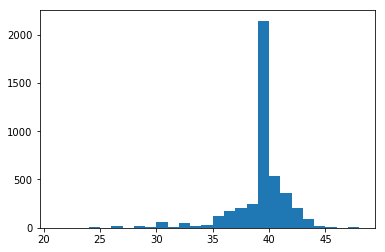

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
data = fdf.wksgest[(fdf.wksgest > 20) & (fdf.wksgest < 54)]
data.dropna()
print(len(data))
numbins = int(max(data)-min(data))
plt.hist(data, bins=numbins)
print(data.value_counts().head())

We clearly see the vast majority of births take place at the 39th week - and that overall there is more of a tendency to be late than early (the number of births in the 40 and 41 weeks buckets are 4 times those in the 38 bucket).

Now the question remains, how does that compare to a second, third or 4th child? Let's plot all of those together:

number of births for child 1: 4347
	number of births on early, on time, late: 22.52%, 49.30%, 28.18%
	mean, standard deviation: 38.71, 38.71
number of births for child 2: 2822
	number of births on early, on time, late: 23.46%, 53.15%, 23.39%
	mean, standard deviation: 38.65, 38.65
number of births for child 3: 1196
	number of births on early, on time, late: 22.24%, 56.10%, 21.66%
	mean, standard deviation: 38.59, 38.59
number of births for child 4: 407
	number of births on early, on time, late: 20.39%, 61.67%, 17.94%
	mean, standard deviation: 38.60, 38.60


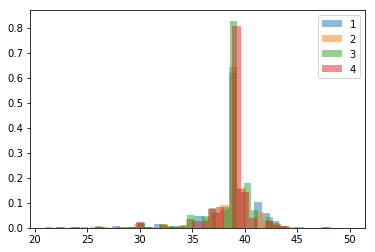

In [103]:
numbins = 34
for idx in range(1,5):
    child_n = df[df['pregend1'].isin([5,6]) & ((df['multbrth'] == 5) | df['multbrth'].isnull()) & (df['birthord'] == idx)]
    data = child_n.wksgest[(child_n.wksgest > 20) & (child_n.wksgest < 54)]
    data.dropna() # yep - data isn't that clean
    plt.hist(data, bins=numbins, alpha=0.5, label='{0}'.format(idx), normed=1)
    total = len(data)
    print('number of births for child {0}: {1}'.format(idx, total))
    print('\tnumber of births on early, on time, late: {0:.2f}%, {1:.2f}%, {2:.2f}%'.format(len(data[data < 39])/total*100, 
                                                                       len(data[data == 39])/total*100,
                                                                       len(data[data > 39])/total*100))
    print('\tmean, standard deviation: {0:.2f}, {0:.2f}'.format(data.mean(), data.std()))
plt.legend(loc='upper right')

Note that the histogram above has been normalised (otherwise the peak for child 1 would look a lot higher - there are 4 times as meany 1st child as there are 4th).

It does look like the first child likely to come a little later than expected. Now technically a pregnancy is overdue at 42 weeks and above and pre-term at 37 and below. Taking this into account, let's see if this changes anything:

In [110]:
numbins = 34
for idx in range(1,5):
    child_n = df[df['pregend1'].isin([5,6]) & ((df['multbrth'] == 5) | df['multbrth'].isnull()) & (df['birthord'] == idx)]
    data = child_n.wksgest[(child_n.wksgest > 20) & (child_n.wksgest < 54)]
    data.dropna() # yep - data isn't that clean
    total = len(data)
    print('number of births for child {0}: {1}'.format(idx, total))
    print('\tnumber of births on early, on time, late: {0:.2f}%, {1:.2f}%, {2:.2f}%'.format(len(data[data <= 37])/total*100, 
                                                                       len(38 <= data[data <= 41])/total*100,
                                                                       len(data[data >= 42])/total*100))
    print('\tmean, standard deviation: {0:.2f}, {0:.2f}'.format(data.mean(), data.std()))

number of births for child 1: 4347
	number of births on early, on time, late: 16.82%, 92.41%, 7.59%
	mean, standard deviation: 38.71, 38.71
number of births for child 2: 2822
	number of births on early, on time, late: 15.91%, 95.00%, 5.00%
	mean, standard deviation: 38.65, 38.65
number of births for child 3: 1196
	number of births on early, on time, late: 16.56%, 95.48%, 4.52%
	mean, standard deviation: 38.59, 38.59
number of births for child 4: 407
	number of births on early, on time, late: 14.00%, 96.07%, 3.93%
	mean, standard deviation: 38.60, 38.60


And it doesn't - not only are first borns more likely to be late, they're also more likely to be early. If anything, they're the less likely to be on time!

## Conclusion

What took the longest was sourcing and parsing the data - that's probably 80% of the time spent there and only 20% on the actual analysis. On the plus side it looks we did manage to support the original hypothesis - though with more (relevant) context.